In [1]:
import torch
import torch.nn as nn
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
# Our imports
from core_code.datasets.fer2013 import FER2013
from core_code.datasets.fer2013_expanded import FER2013Exp
from core_code.models.emotion_net import EmotionNet
from core_code.models.byol_model import BYOL, BYOL_Fine_Tune
from core_code.core_utils.globals import device, NUM_OF_CLASSES
from core_code.core_utils.transforms import test_transformations
from core_code.core_utils.plots import confusion_matrix, PLOTS_DIR
from core_code.core_utils.parse_log import plot_from_log

from importlib import reload
import core_code.core_utils.plots
reload(core_code.core_utils.plots)
from core_code.core_utils.plots import confusion_matrix, PLOTS_DIR


In [2]:
# function to calcualte accuracy of the model
def calculate_accuracy(model, device, dataloader, criterion, create_confusion_matrix=True, best_2=False):
    model.eval() # put in evaluation mode,  turn off Dropout, BatchNorm uses learned statistics
    total_correct = 0
    total_images = 0
    running_loss = 0.0
    confusion_matrix = np.zeros([NUM_OF_CLASSES, NUM_OF_CLASSES], int)
    with torch.no_grad():
        for data in dataloader:
            # Evaluate model on data
            images, labels, _ = data
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            
            # Calculate loss
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            if not best_2:
                # Calculate accuracy & confusion matrix
                _, predicted = torch.max(outputs.data, 1)
                total_images += labels.size(0)
                total_correct += (predicted == labels).sum().item()
                if create_confusion_matrix:
                    for i, l in enumerate(labels):
                        confusion_matrix[l.item(), predicted[i].item()] += 1
            else:
                # Calculate top 2 predictions
                _, top2_predicted = torch.topk(outputs, 2, dim=1)
                total_images += labels.size(0)
                for i, l in enumerate(labels):
                    true_label = l.item()
                    predicted_labels = top2_predicted[i].tolist()
                    if true_label in predicted_labels:
                        # True label in top 2 predictions
                        if predicted_labels[0] == true_label or predicted_labels[1] == true_label:
                            total_correct += 1
                    else:
                        # True label not in top 2 predictions, count as a miss
                        total_correct += 0
            
            
            
    total_loss = running_loss / len(dataloader.dataset)
    model_accuracy = total_correct / total_images * 100
    return model_accuracy, confusion_matrix, total_loss

def calculate_normalized_accuracy(confusion_matrix):
    cm_normalized = confusion_matrix.astype('float') / confusion_matrix.sum(axis=1)[:, np.newaxis]
    return np.mean(np.diag(cm_normalized)) * 100.0

In [3]:
test_data = FER2013(phase='test', emotion_transform_prob=0, transform=test_transformations)
validation_data = FER2013(phase='val', emotion_transform_prob=0, transform=test_transformations)

Dataset already processed.
Dataset already processed.


In [4]:
test_loader = torch.utils.data.DataLoader(test_data, batch_size=8, shuffle=False)
validation_loader = torch.utils.data.DataLoader(validation_data, batch_size=8, shuffle=False)
criterion = nn.CrossEntropyLoss()
#ckpt_byol_{net_name}_{exp_name}_last_trained_epoch.pth

In [5]:
def load_model(checkpoint_dir='checkpoints', name='resnet50',exp_name="Regular", byol=False, final=False, based_byol=False):
    if byol:
        net = EmotionNet(name=name)
        backbone = nn.Sequential(*list(net.nn_model.children())[:-1])
        model = BYOL(backbone=backbone, net=name)
        filename = os.path.join(checkpoint_dir, f'ckpt_byol_{name}_{exp_name}_last_trained_epoch.pth')
    elif based_byol:
        net = EmotionNet(name=name)
        backbone = nn.Sequential(*list(net.nn_model.children())[:-1])
        byol_tmp = BYOL(backbone=backbone, net=name)
        model = BYOL_Fine_Tune(byol_tmp.backbone, name=name, experiment_name=exp_name).to(device)
        filename = os.path.join(checkpoint_dir, f'ckpt_{name}_{exp_name}_best_validation.pth')
    else:
        model = EmotionNet(name=name)
        if final:
            filename = os.path.join(checkpoint_dir, f'ckpt_{name}_{exp_name}_final_checkpoint.pth')
        else:
            filename = os.path.join(checkpoint_dir, f'ckpt_{name}_{exp_name}_best_validation.pth')
    model.load_state_dict(torch.load(filename)['net'])
    return model

In [6]:
MODEL_RESNET = "resnet18"
MODEL_DENSENET = "densenet201"
MODEL_DINO = "dino_v2"

In [7]:
# Load all resnet:
best_resnet_regular_model = load_model(name=MODEL_RESNET, exp_name="Regular_New_Transforms_No_Normalization").to(device)
best_resnet_aug_model = load_model(name=MODEL_RESNET, exp_name="Augmented_New_Transforms_No_Normalization").to(device)
best_resnet_expanded_model = load_model(name=MODEL_RESNET, exp_name="Expanded_New_Transforms_No_Normalization").to(device)

In [8]:
# Load all densnet
best_densenet_regular_model = load_model(name=MODEL_DENSENET, exp_name="Regular_New_Transforms_No_Normalization").to(device)
best_densenet_aug_model = load_model(name=MODEL_DENSENET, exp_name="Augmented_New_Transforms_No_Normalization").to(device)
best_densenet_expanded_model = load_model(name=MODEL_DENSENET, exp_name="Expanded_New_Transforms_No_Normalization").to(device)

In [7]:
# Load all dino_v2
best_dino_regular_model = load_model(name=MODEL_DINO, exp_name="Regular_New_Transforms_No_Normalization").to(device)
best_dino_aug_model = load_model(name=MODEL_DINO, exp_name="Augmented_New_Transforms_No_Normalization").to(device)

Using cache found in /home/amitshawn/.cache/torch/hub/facebookresearch_dinov2_main
/home/amitshawn/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/swiglu_ffn.py:51: UserWarning: xFormers is not available (SwiGLU)
  warnings.warn("xFormers is not available (SwiGLU)")
/home/amitshawn/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/attention.py:33: UserWarning: xFormers is not available (Attention)
  warnings.warn("xFormers is not available (Attention)")
/home/amitshawn/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/block.py:40: UserWarning: xFormers is not available (Block)
  warnings.warn("xFormers is not available (Block)")


	 head.weight
	 head.bias


Using cache found in /home/amitshawn/.cache/torch/hub/facebookresearch_dinov2_main


	 head.weight
	 head.bias


In [8]:
best_2 = False

In [10]:
val_resnet_reg_accuracy, val_resnet_reg_confusion_matrix, _ = calculate_accuracy(best_resnet_regular_model, device, validation_loader, criterion, create_confusion_matrix=True,best_2=best_2)
test_resnet_reg_accuracy, test_resnet_reg_confusion_matrix, _ = calculate_accuracy(best_resnet_regular_model, device, test_loader, criterion, create_confusion_matrix=True,best_2=best_2)

In [11]:
val_resnet_exp_accuracy, val_resnet_exp_confusion_matrix, _ = calculate_accuracy(best_resnet_expanded_model, device, validation_loader, criterion, create_confusion_matrix=True,best_2=best_2)
test_resnet_exp_accuracy, test_resnet_exp_confusion_matrix, _ = calculate_accuracy(best_resnet_expanded_model, device, test_loader, criterion, create_confusion_matrix=True,best_2=best_2)

In [12]:
val_resnet_aug_accuracy, val_resnet_aug_confusion_matrix, _ = calculate_accuracy(best_resnet_aug_model, device, validation_loader, criterion, create_confusion_matrix=True,best_2=best_2)
test_resnet_aug_accuracy, test_resnet_aug_confusion_matrix, _ = calculate_accuracy(best_resnet_aug_model, device, test_loader, criterion, create_confusion_matrix=True,best_2=best_2)

In [18]:
val_densenet_reg_accuracy, val_densenet_reg_confusion_matrix, _ = calculate_accuracy(best_densenet_regular_model, device, validation_loader, criterion, create_confusion_matrix=True,best_2=best_2)
test_densenet_reg_accuracy, test_densenet_reg_confusion_matrix, _ = calculate_accuracy(best_densenet_regular_model, device, test_loader, criterion, create_confusion_matrix=True,best_2=best_2)

In [19]:
val_densenet_exp_accuracy, val_densenet_exp_confusion_matrix, _ = calculate_accuracy(best_densenet_expanded_model, device, validation_loader, criterion, create_confusion_matrix=True,best_2=best_2)
test_densenet_exp_accuracy, test_densenet_exp_confusion_matrix, _ = calculate_accuracy(best_densenet_expanded_model, device, test_loader, criterion, create_confusion_matrix=True,best_2=best_2)

In [20]:
val_densenet_aug_accuracy, val_densenet_aug_confusion_matrix, _ = calculate_accuracy(best_densenet_aug_model, device, validation_loader, criterion, create_confusion_matrix=True,best_2=best_2)
test_densenet_aug_accuracy, test_densenet_aug_confusion_matrix, _ = calculate_accuracy(best_densenet_aug_model, device, test_loader, criterion, create_confusion_matrix=True,best_2=best_2)

In [15]:
best_2 = False
test_dino_reg_accuracy, test_dino_reg_confusion_matrix, _ = calculate_accuracy(best_dino_regular_model, device, test_loader, criterion, create_confusion_matrix=True,best_2=best_2)
test_dino_aug_accuracy, test_dino_aug_confusion_matrix, _ = calculate_accuracy(best_dino_aug_model, device, test_loader, criterion, create_confusion_matrix=True,best_2=best_2)

In [16]:
print("Results Dino:")
print(f"Regular test result: {test_dino_reg_accuracy:.4}%")
print(f"Augmented test result: {test_dino_aug_accuracy:.4}%")
# print(f"Expanded test result: {test_dino_exp_accuracy:.4}%")

Results Dino:
Regular test result: 56.39%
Augmented test result: 53.86%


Accuracy: 56.395%
Accuracy: 53.859%


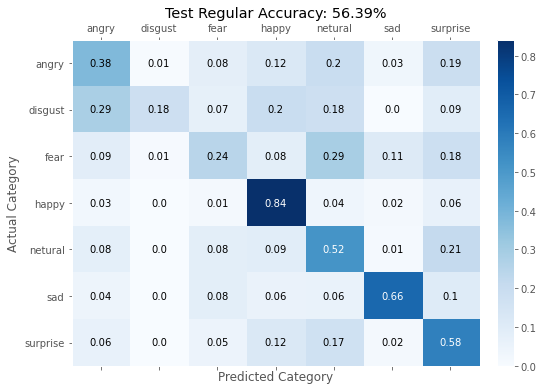

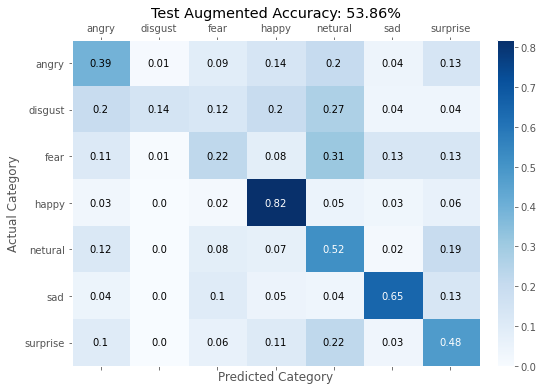

In [12]:
confusion_matrix(best_dino_regular_model,test_dino_reg_confusion_matrix, accuracy=test_dino_reg_accuracy, test_name="Test Regular", to_save=True)
confusion_matrix(best_dino_aug_model,test_dino_aug_confusion_matrix, accuracy=test_dino_aug_accuracy, test_name="Test Augmented", to_save=True)


In [23]:
print(f"Showing REsults Of Best {2 if best_2 else 1}")
print("Results Resnet:")
print(f"Regular test result: {test_resnet_reg_accuracy:.4}%")
print(f"Augmented test result: {test_resnet_aug_accuracy:.4}%")
print(f"Expanded test result: {test_resnet_exp_accuracy:.4}%")
print('\n', end='')
print(f"Normalized Regular test result: {calculate_normalized_accuracy(test_resnet_reg_confusion_matrix):.4}%")
print(f"Normalized Augmented test result: {calculate_normalized_accuracy(test_resnet_aug_confusion_matrix):.4}%")
print(f"Normalized Expanded test result: {calculate_normalized_accuracy(test_resnet_exp_confusion_matrix):.4}%")
print('\n', end='')
print("Results DenseNet:")
print(f"Regular test result: {test_densenet_reg_accuracy:.4}%")
print(f"Augmented test result: {test_densenet_aug_accuracy:.4}%")
print(f"Expanded test result: {test_densenet_exp_accuracy:.4}%")
print('\n', end='')
print(f"Normalized Regular test result: {calculate_normalized_accuracy(test_densenet_reg_confusion_matrix):.4}%")
print(f"Normalized Augmented test result: {calculate_normalized_accuracy(test_densenet_aug_confusion_matrix):.4}%")
print(f"Normalized Expanded test result: {calculate_normalized_accuracy(test_densenet_exp_confusion_matrix):.4}%")


Showing REsults Of Best 0
Results Resnet:
Regular test result: 70.16%
Augmented test result: 69.6%
Expanded test result: 69.55%

Normalized Regular test result: 68.34%
Normalized Augmented test result: 67.33%
Normalized Expanded test result: 68.48%

Results DenseNet:
Regular test result: 70.3%
Augmented test result: 69.57%
Expanded test result: 68.1%

Normalized Regular test result: 68.58%
Normalized Augmented test result: 68.07%
Normalized Expanded test result: 65.96%


Resnet Confusion Matrix
Accuracy: 70.159%
Accuracy: 69.602%
Accuracy: 69.546%
DenseNet Confusion Matrix
Accuracy: 70.298%
Accuracy: 69.574%
Accuracy: 68.097%


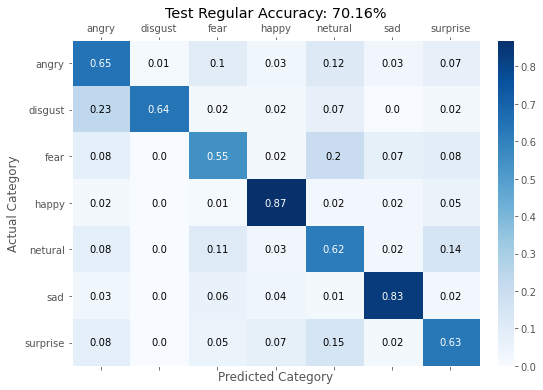

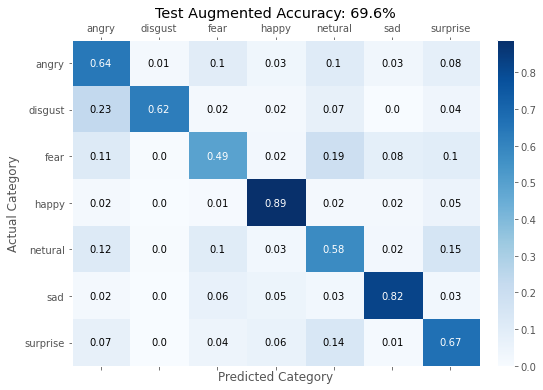

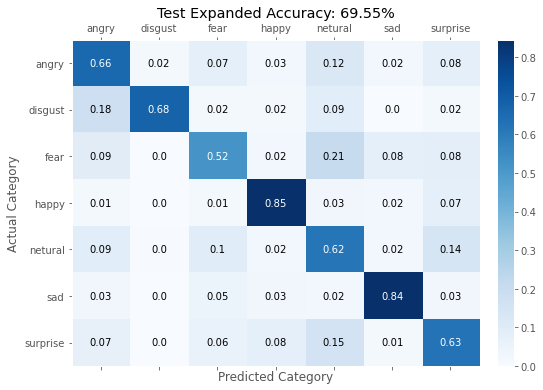

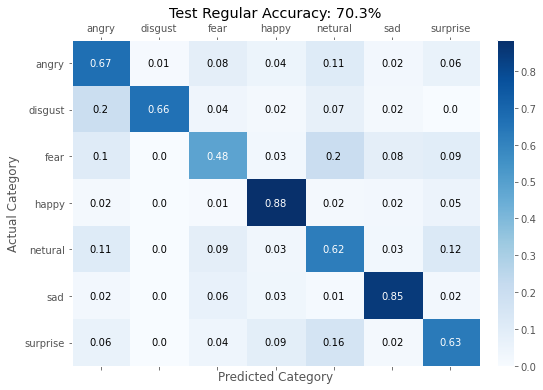

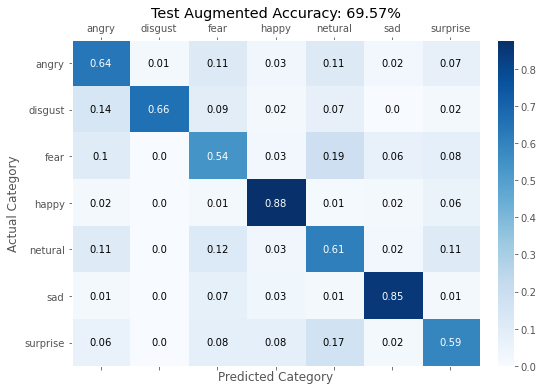

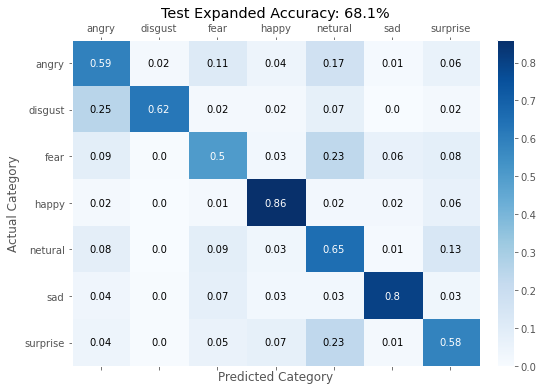

In [38]:
print("Resnet Confusion Matrix")
confusion_matrix(best_resnet_regular_model,test_resnet_reg_confusion_matrix, accuracy=test_resnet_reg_accuracy, test_name="Test Regular", to_save=True)
confusion_matrix(best_resnet_aug_model,test_resnet_aug_confusion_matrix, accuracy=test_resnet_aug_accuracy, test_name="Test Augmented", to_save=True)
confusion_matrix(best_resnet_expanded_model, test_resnet_exp_confusion_matrix, accuracy=test_resnet_exp_accuracy, test_name="Test Expanded", to_save=True)
print("DenseNet Confusion Matrix")
confusion_matrix(best_densenet_regular_model,test_densenet_reg_confusion_matrix, accuracy=test_densenet_reg_accuracy, test_name="Test Regular", to_save=True)
confusion_matrix(best_densenet_aug_model,test_densenet_aug_confusion_matrix, accuracy=test_densenet_aug_accuracy, test_name="Test Augmented", to_save=True)
confusion_matrix(best_densenet_expanded_model, test_densenet_exp_confusion_matrix, accuracy=test_densenet_exp_accuracy, test_name="Test Expanded", to_save=True)

In [43]:
BYOL_MODEL = "resnet18"
byol_based_model = load_model(name=BYOL_MODEL, exp_name="BYOL_No_Normalization",based_byol=True).to(device)
byol_val_accuracy, byol_val_confusion_matrix, _ = calculate_accuracy(byol_based_model, device, validation_loader, criterion, create_confusion_matrix=True)
byol_test_accuracy, byol_test_confusion_matrix, _ = calculate_accuracy(byol_based_model, device, test_loader, criterion, create_confusion_matrix=True)

Results:
BYOL test result: 69.13%
Accuracy: 69.128%
Accuracy: 70.159%


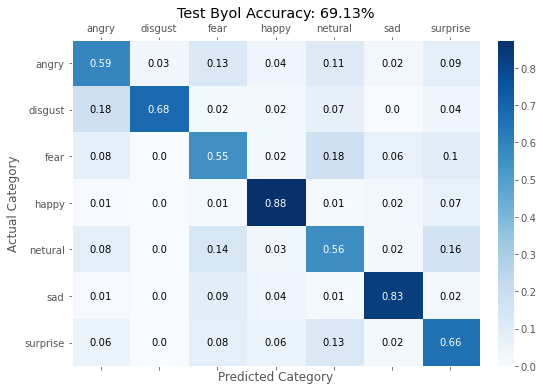

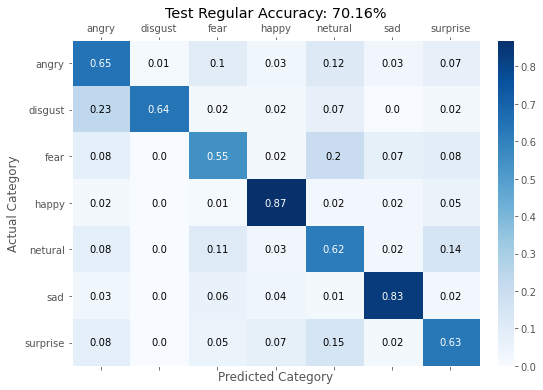

In [45]:
print("Results:")
print(f"BYOL test result: {byol_test_accuracy:.4}%")
confusion_matrix(byol_based_model, byol_test_confusion_matrix, accuracy=byol_test_accuracy, test_name="Test Byol", to_save=True)
confusion_matrix(best_resnet_regular_model,test_resnet_reg_confusion_matrix, accuracy=test_resnet_reg_accuracy, test_name="Test Regular", to_save=False)


In [39]:
# function to calcualte accuracy of the model
def calculate_accuracy_combine_models(model_list, device, dataloader, criterion, create_confusion_matrix=True):
    model_list[0].eval() # put in evaluation mode,  turn off Dropout, BatchNorm uses learned statistics
    model_list[1].eval()
    total_correct = 0
    total_images = 0
    running_loss = 0.0
    confusion_matrix = np.zeros([NUM_OF_CLASSES, NUM_OF_CLASSES], int)
    with torch.no_grad():
        for data in dataloader:
            # Evaluate model on data
            images, labels, _ = data
            images = images.to(device)
            labels = labels.to(device)
            output1 = model_list[0](images)
            output2 = model_list[1](images)
            output3 = model_list[2](images)
            
            # Calculate accuracy & confusion matrix
            max_value1, predicted1 = torch.max(output1.data, 1)
            max_value2, predicted2 = torch.max(output2.data, 1)
            max_value3, predicted3 = torch.max(output3.data, 1)
            predicted = torch.zeros((len(predicted1))).to(device)
            
            for iMax in range(len(predicted1)):
                if max_value1[iMax] >= max_value2[iMax] and max_value1[iMax] >= max_value3[iMax]:
                    predicted[iMax] = predicted1[iMax]
                elif max_value2[iMax] >= max_value3[iMax]:
                    predicted[iMax] = predicted2[iMax]
                else:
                    predicted[iMax] = predicted3[iMax]
                
            total_images += labels.size(0)
            total_correct += (predicted == labels).sum().item()
            if create_confusion_matrix:
                for i, l in enumerate(labels):
                    confusion_matrix[l.item(), predicted[i].cpu().numpy().astype(np.uint8)] += 1
            
    model_accuracy = total_correct / total_images * 100
    return model_accuracy, confusion_matrix

In [60]:
test_combined_acc, test_combined_confusion_mat = calculate_accuracy_combine_models([best_resnet_expanded_model,byol_based_model,best_resnet_aug_model], device, test_loader, criterion, create_confusion_matrix=True)
#val_combined_acc, val_combined_confusion_mat= calculate_accuracy_combine_models([best_regular_model,best_expanded_model,best_aug_model], device, validation_loader, criterion, create_confusion_matrix=True)

In [61]:
print(f"Combined test result: {test_combined_acc:.4}%")
#print(f"Combined validation result: {val_combined_acc:.4}%")

Combined test result: 71.47%


Accuracy: 71.468%


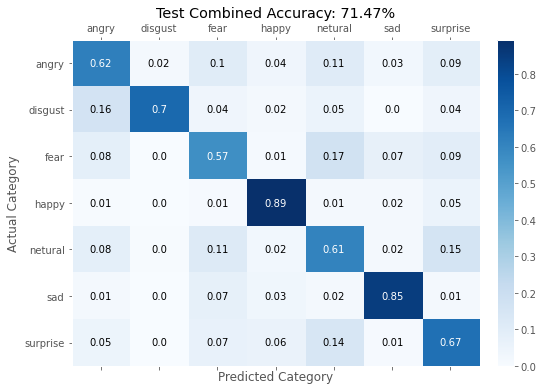

In [62]:
combined_model = EmotionNet(MODEL_RESNET, experiment_name='combined')
confusion_matrix(combined_model, test_combined_confusion_mat, accuracy=test_combined_acc, test_name="Test Combined", to_save=True)

In [10]:
# TSNE parameters:
n_points = 2000
n_components = 2


In [8]:
import copy
def extract_features(model, model_name):
    if model_name == 'resnet18':
        to_return = copy.deepcopy(model)
        to_return.fc = nn.Identity()
    return to_return

In [9]:
train_data_no_augment = FER2013(phase='train', emotion_transform_prob=0, transform=test_transformations)
train_data_augment = FER2013(phase='train', emotion_transform_prob=1, transform=test_transformations)

train_loader_no_augment = torch.utils.data.DataLoader(train_data_no_augment, batch_size=n_points, shuffle=False)
train_loader_augment = torch.utils.data.DataLoader(train_data_augment, batch_size=n_points, shuffle=False)

Dataset already processed.
Dataset already processed.


In [11]:
# TSNE to the regular model, on the augmented dataset and regular dataset:
# device = torch.device('cpu')
final_resnet_regular_model = load_model(name=MODEL_RESNET, exp_name="Regular_Few_Epochs", final=True).to(device)
final_resnet_augmented_model = load_model(name=MODEL_RESNET, exp_name="Augmented_Few_Epochs", final=True).to(device)

images_no_augment, labels_no_augment, _ = next(iter(train_loader_no_augment))
images_augment, labels_augment, _ = next(iter(train_loader_augment))

regular_model_tsne = extract_features(final_resnet_regular_model, MODEL_RESNET).eval()
aug_model_tsne = extract_features(final_resnet_augmented_model, MODEL_RESNET).eval()

with torch.no_grad():
    latent_images_no_augment = regular_model_tsne(images_no_augment.to(device)).to(device).data.cpu().numpy()
    latent_images_augment = aug_model_tsne(images_augment.to(device)).to(device).data.cpu().numpy()

In [12]:
    
labels_no_augment = labels_no_augment.data.cpu().numpy()
embedded_no_augment = TSNE(n_components=n_components).fit_transform(latent_images_no_augment)

labels_augment = labels_augment.data.cpu().numpy()
embedded_augment = TSNE(n_components=n_components).fit_transform(latent_images_augment)

/home/amitshawn/anaconda3/envs/deep/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/amitshawn/anaconda3/envs/deep/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/home/amitshawn/anaconda3/envs/deep/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/amitshawn/anaconda3/envs/deep/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


In [13]:
label_names = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

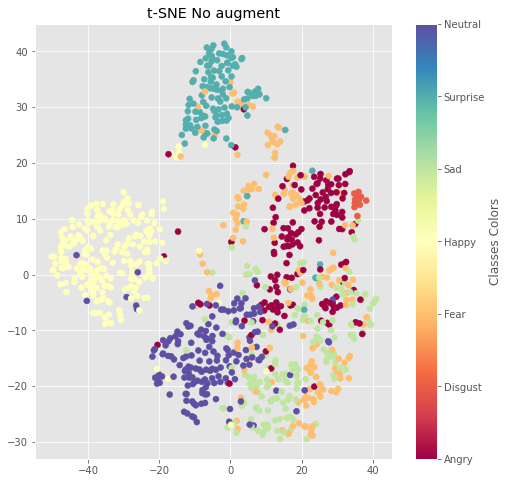

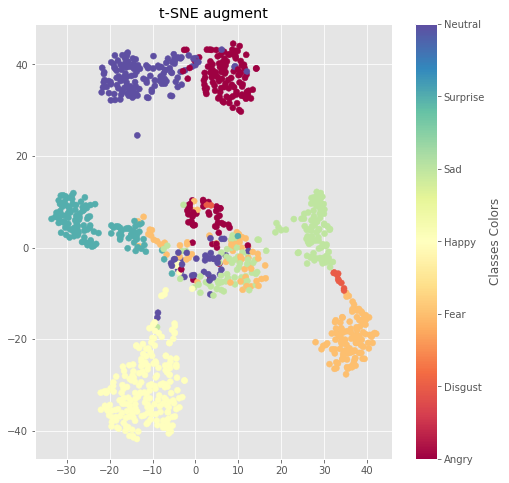

In [14]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
scatter = ax.scatter(embedded_no_augment[:, 0], embedded_no_augment[:, 1], c=labels_no_augment, cmap=plt.cm.Spectral)
ax.set_title('t-SNE No augment')
bounds = np.linspace(0, 7, 8)
cb = plt.colorbar(scatter, spacing='proportional',ticks=bounds, label=label_names)
cb.set_label('Classes Colors')
cb.set_ticks(bounds)
cb.set_ticklabels(label_names)

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
scatter = ax.scatter(embedded_augment[:, 0], embedded_augment[:, 1], c=labels_augment, cmap=plt.cm.Spectral)
ax.set_title('t-SNE augment')
bounds = np.linspace(0, 7, 8)
cb = plt.colorbar(scatter, spacing='proportional',ticks=bounds, label=label_names)
cb.set_label('Classes Colors')
cb.set_ticks(bounds)
cb.set_ticklabels(label_names)

In [23]:
device = torch.device('cpu')
byol_model = load_model(name="resnet18", exp_name="BYOL_MORE_EPOCHS", byol=True).to(device).eval()

train_data_augment = FER2013(phase='train', emotion_transform_prob=1, transform=test_transformations)
train_loader_augment = torch.utils.data.DataLoader(train_data_augment, batch_size=n_points, shuffle=False)
images_augment, labels_augment, _ = next(iter(train_loader_augment))

with torch.no_grad():
    latent_images_byol = byol_model(images_augment.to(device)).to(device).data.cpu().numpy()
labels_byol = labels_augment.data.cpu().numpy()
embedded_byol_feautures = TSNE(n_components=n_components).fit_transform(latent_images_byol)

Dataset already processed.


/home/amitshawn/anaconda3/envs/deep/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/amitshawn/anaconda3/envs/deep/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


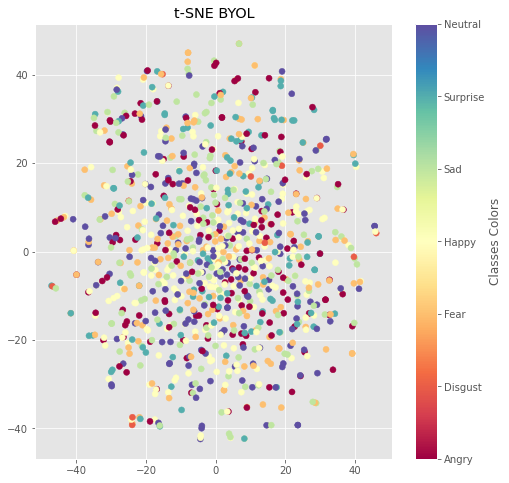

In [24]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
scatter = ax.scatter(embedded_byol_feautures[:, 0], embedded_byol_feautures[:, 1], c=labels_no_augment, cmap=plt.cm.Spectral)
ax.set_title('t-SNE BYOL')
bounds = np.linspace(0, 7, 8)
cb = plt.colorbar(scatter, spacing='proportional',ticks=bounds, label=label_names)
cb.set_label('Classes Colors')
cb.set_ticks(bounds)
cb.set_ticklabels(label_names)

In [ ]:
device = torch.device('cpu')
byol_model = load_model(name="resnet18", exp_name="BYOL_MORE_EPOCHS", byol=True).to(device)
byol_model_tsne = extract_features(byol_model,'resnet18').eval()

test_loader = torch.utils.data.DataLoader(test_data, batch_size=n_points, shuffle=False)
images, labels, _ = next(iter(test_loader))
with torch.no_grad():
    latent_images_byol = byol_model_tsne(images).to(device).data.cpu().numpy()
labels = labels.data.cpu().numpy()
embedded_byol_feautures = TSNE(n_components=n_components).fit_transform(byol_model_tsne)

fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111)
scatter = ax.scatter(embedded_byol_feautures[:, 0], embedded_byol_feautures[:, 1], c=labels, cmap=plt.cm.Spectral)
ax.set_title('t-SNE byol')
bounds = np.linspace(0, 7, 8)
cb = plt.colorbar(scatter, spacing='proportional',ticks=bounds)
cb.set_label('Classes Colors')

In [16]:
test_byol_accuracy, _, _ = calculate_accuracy(byol_model, device, test_loader, criterion, create_confusion_matrix=False)

In [ ]:
print(f"Test Byol Pretrained weights: {test_byol_accuracy:.4}%")

In [8]:
regular_model = load_model(name=MODEL_TO_TEST, exp_name="Regular_New_Transforms_No_Normalization").to(torch.device('cpu'))
augmented_model = load_model(name=MODEL_TO_TEST, exp_name="Augmented_New_Transforms_No_Normalization").to(torch.device('cpu'))
expanded_model = load_model(name=MODEL_TO_TEST, exp_name="Expanded_New_Transforms_No_Normalization").to(torch.device('cpu'))

In [9]:
regular_model_tsne = extract_features(regular_model, MODEL_TO_TEST).eval()
augmented_model_tsne = extract_features(augmented_model, MODEL_TO_TEST).eval()
expanded_model_tsne = extract_features(expanded_model, MODEL_TO_TEST).eval()

In [10]:
test_loader = torch.utils.data.DataLoader(test_data, batch_size=n_points, shuffle=False)
images, labels, _ = next(iter(test_loader))
with torch.no_grad():
    latent_images_regular = regular_model_tsne(images.to(torch.device('cpu'))).data.cpu().numpy()
    latent_images_augmented = augmented_model_tsne(images.to(torch.device('cpu'))).data.cpu().numpy()
    latent_images_expanded = expanded_model_tsne(images.to(torch.device('cpu'))).data.cpu().numpy()
labels = labels.data.cpu().numpy()

In [11]:
embedded_regular_feautures = TSNE(n_components=n_components).fit_transform(latent_images_regular)
embedded_augmented_feautures = TSNE(n_components=n_components).fit_transform(latent_images_augmented)
embedded_expanded_feautures = TSNE(n_components=n_components).fit_transform(latent_images_expanded)

/home/amitshawn/anaconda3/envs/deep/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/amitshawn/anaconda3/envs/deep/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


/home/amitshawn/anaconda3/envs/deep/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/amitshawn/anaconda3/envs/deep/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/home/amitshawn/anaconda3/envs/deep/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/amitshawn/anaconda3/envs/deep/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


In [66]:
label_names = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

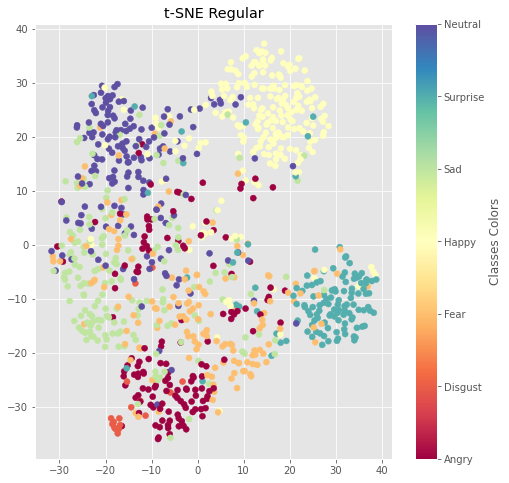

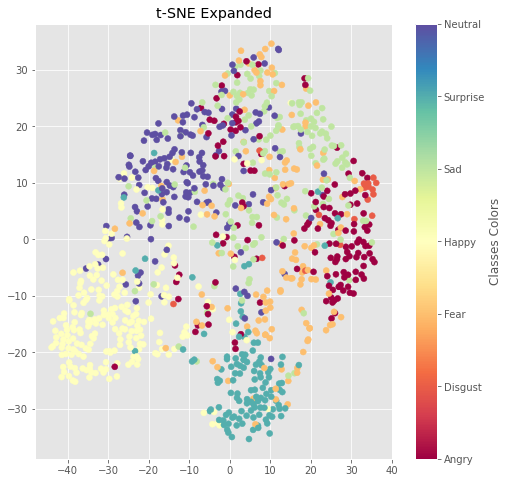

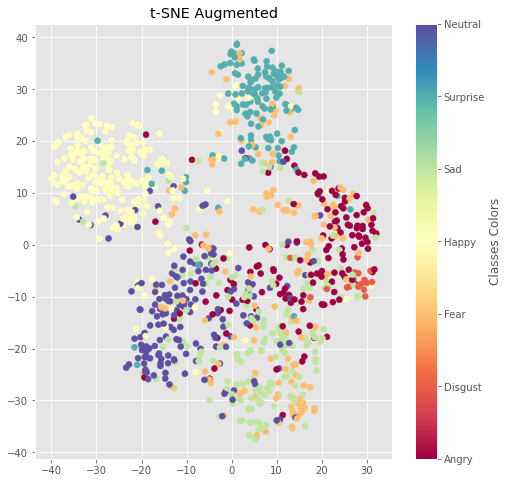

In [14]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
scatter = ax.scatter(embedded_regular_feautures[:, 0], embedded_regular_feautures[:, 1], c=labels, cmap=plt.cm.Spectral)
ax.set_title('t-SNE Regular')
bounds = np.linspace(0, 7, 8)
cb = plt.colorbar(scatter, spacing='proportional',ticks=bounds, label=label_names)
cb.set_label('Classes Colors')
cb.set_ticks(bounds)
cb.set_ticklabels(label_names)

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
scatter = ax.scatter(embedded_expanded_feautures[:, 0], embedded_expanded_feautures[:, 1], c=labels, cmap=plt.cm.Spectral)
ax.set_title('t-SNE Expanded')
bounds = np.linspace(0, 7, 8)
cb = plt.colorbar(scatter, spacing='proportional',ticks=bounds, label=label_names)
cb.set_label('Classes Colors')
cb.set_ticks(bounds)
cb.set_ticklabels(label_names)

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
scatter = ax.scatter(embedded_augmented_feautures[:, 0], embedded_augmented_feautures[:, 1], c=labels, cmap=plt.cm.Spectral)
ax.set_title('t-SNE Augmented')
bounds = np.linspace(0, 7, 8)
cb = plt.colorbar(scatter, spacing='proportional',ticks=bounds, label=label_names)
cb.set_label('Classes Colors')
cb.set_ticks(bounds)
cb.set_ticklabels(label_names)


In [40]:
for i in range(7):
    regular_var = np.var(embedded_regular_feautures[labels==i][:,0]) + np.var(embedded_regular_feautures[labels==i][:,1])
    augmented_var = np.var(embedded_augmented_feautures[labels==i][:,0]) + np.var(embedded_augmented_feautures[labels==i][:,1])
    expanded_var = np.var(embedded_expanded_feautures[labels==i][:,0]) + np.var(embedded_expanded_feautures[labels==i][:,1])
    print(f"{i}:\n\tregular: {regular_var}\n\taugmented: {augmented_var}\n\texpanded: {expanded_var}")

0:
	regular: 304.305908203125
	augmented: 249.91983032226562
	expanded: 351.37811279296875
1:
	regular: 96.47655487060547
	augmented: 27.270254135131836
	expanded: 228.23974609375
2:
	regular: 337.30859375
	augmented: 514.0726318359375
	expanded: 428.03887939453125
3:
	regular: 231.80177307128906
	augmented: 218.31863403320312
	expanded: 219.02969360351562
4:
	regular: 301.10858154296875
	augmented: 294.6865234375
	expanded: 312.3345947265625
5:
	regular: 218.7138671875
	augmented: 174.11196899414062
	expanded: 170.426513671875
6:
	regular: 233.20004272460938
	augmented: 220.4793701171875
	expanded: 239.37677001953125


In [59]:
def count_labels(dataset):
    # Count the number of images for each label
    label_counts = {i: 0 for i in range(NUM_OF_CLASSES)}
    for _, label, _ in dataset:
        label_counts[label] += 1
    return label_counts

In [60]:
regular_train_data = FER2013(phase='train', emotion_transform_prob=0, transform=test_transformations)  # load with test transform for simplicity
expanded_train_data = FER2013Exp(phase='train', transform=test_transformations)

regular_train_label_count = count_labels(regular_train_data)
expanded_train_label_count = count_labels(expanded_train_data)

Dataset already processed.
Dataset already processed.
Expanded Dataset already processed


In [65]:
regular_train_label_count, expanded_train_label_count
regular_train_label_count

{0: 3995, 1: 436, 2: 4097, 3: 7215, 4: 4830, 5: 3171, 6: 4965}

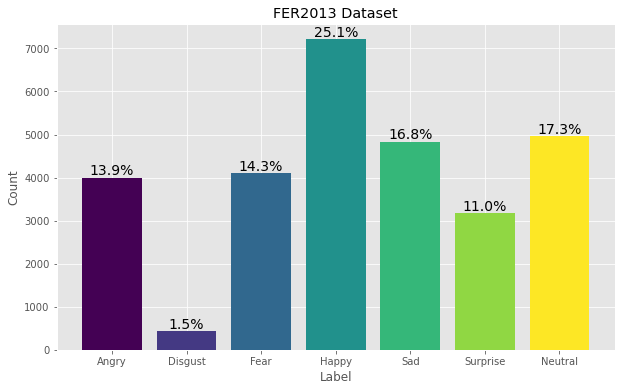

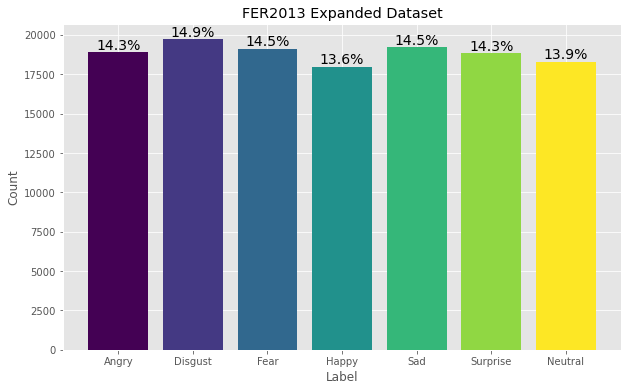

In [92]:
regular_train_count_values = list(regular_train_label_count.values()) 
plt.figure(figsize=(10, 6))
colors = plt.cm.viridis(np.linspace(0, 1, NUM_OF_CLASSES))
bars = plt.bar(label_names, regular_train_count_values, color=colors)
# Add percentage annotations to the bars
for bar in bars:
    height = bar.get_height()
    percentage = (height / sum(regular_train_count_values)) * 100
    plt.text(bar.get_x() + bar.get_width()/2., 
             height, 
             f'{percentage:.1f}%', 
             ha='center', 
             va='bottom', 
             fontsize=14)
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('FER2013 Dataset')
plt.xticks(np.arange(NUM_OF_CLASSES))
plt.savefig(f"{PLOTS_DIR}/fer2013_dataset_distribution.png")
plt.show()

expanded_train_count_values = list(expanded_train_label_count.values()) 
plt.figure(figsize=(10, 6))
colors = plt.cm.viridis(np.linspace(0, 1, NUM_OF_CLASSES))
bars = plt.bar(label_names, expanded_train_count_values, color=colors)
# Add percentage annotations to the bars
for bar in bars:
    height = bar.get_height()
    percentage = (height / sum(expanded_train_count_values)) * 100
    plt.text(bar.get_x() + bar.get_width()/2., 
             height, 
             f'{percentage:.1f}%', 
             ha='center', 
             va='bottom', 
             fontsize=14)
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('FER2013 Expanded Dataset')
plt.xticks(np.arange(NUM_OF_CLASSES))
plt.savefig(f"{PLOTS_DIR}/fer2013_dataset_expanded_distribution.png")
plt.show()

resnet18 Regular_New_Transforms_No_Normalization 100 20
resnet18 Augmented_New_Transforms_No_Normalization 100 20
resnet18 Expanded_New_Transforms_No_Normalization 100 20
densenet201 Regular_New_Transforms_No_Normalization 100 20
densenet201 Augmented_New_Transforms_No_Normalization 100 20
densenet201 Expanded_New_Transforms_No_Normalization 100 20


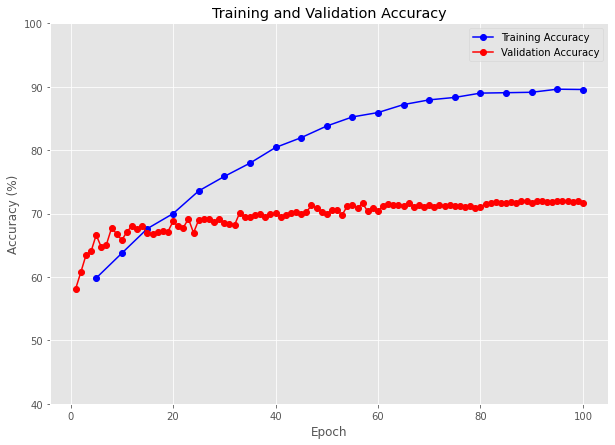

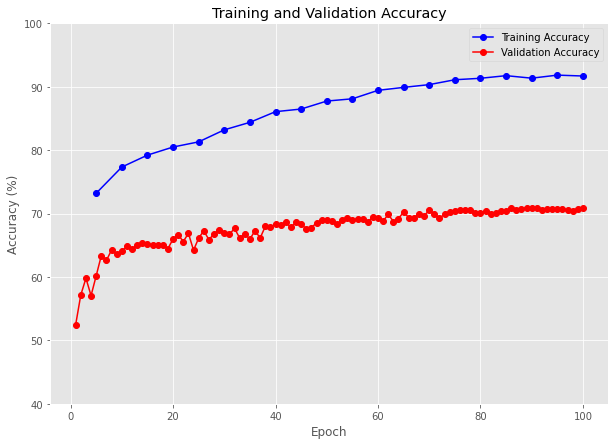

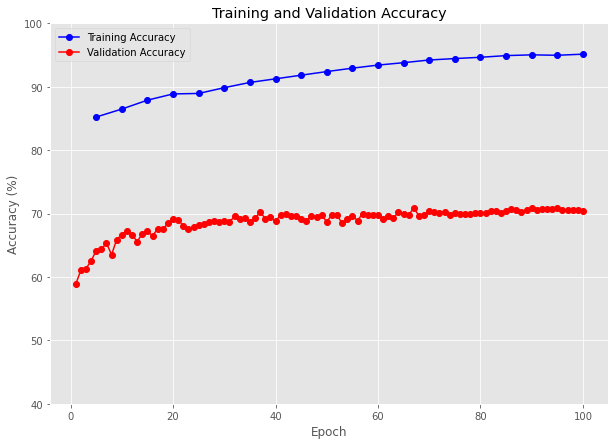

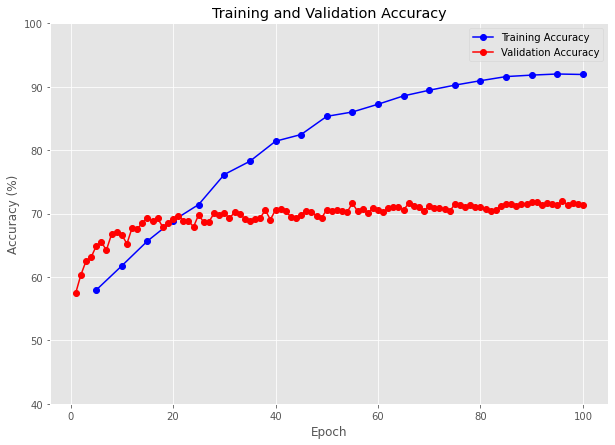

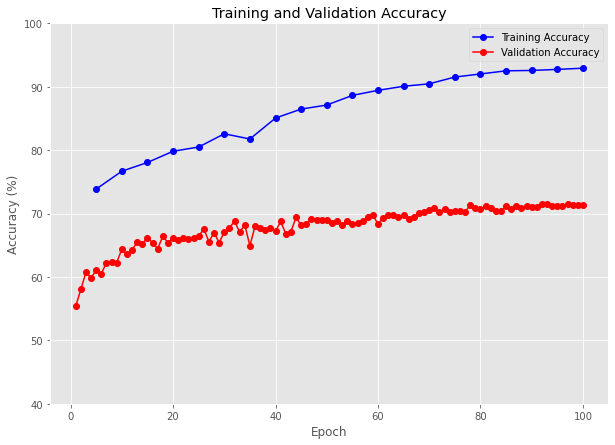

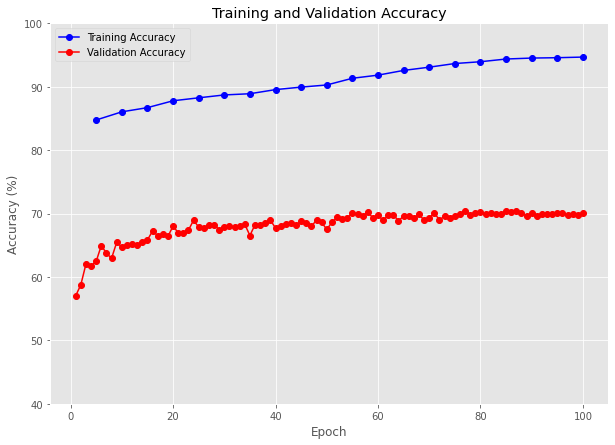

In [3]:
# Plot train validation graphs from logs:

log_files = ['logs/training_2024-03-29-14-44-46.log',  # resnet18 regular
             'logs/training_2024-03-29-17-20-15.log',  # resnet18 augmented
             'logs/training_2024-03-29-21-49-11.log',  # resnet18 expanded
             'logs/training_2024-03-30-14-23-52.log',  # densenet201 regular
             'logs/training_2024-03-30-21-50-12.log',  # densenet201 augmented
             'logs/training_2024-03-31-08-11-22.log',  # densenet201 expanded
             ]

for log_file in log_files:
    plot_from_log(log_file)